# AGH - Deep Learning in Medical Image Analysis I

Author: Marek Wodziński

Contact: wodzinski@agh.edu.pl

You are allowed to use these materials for all purposes as long as the credit is given.


# Laboratory 3 - Datasets, Dataloaders

The goal of the Laboratory 3 is to:
<ul>
  <li> Get familiar with loading images using various I/O libraries.
  <li> Implement several datasets/dataloaders in PyTorch.
  <li> Understand the parameters and limitations of PyTorch dataloaders.
</ul>

You are going to start with simple built-in datasets in torchvision to get familiar with the loading hyperparameters. Then, you will implement three datasets/dataloaders using real medical images.

### Part I - Basic Dataloaders

You are going to start with build-in dataset available in **torchvision** - a library dedicated computer vision in PyTorch. It contains several frequently used datasets for prototyping, like MNIST, CIFAR10 and others. You can check the list of available dataset under the following link:

https://pytorch.org/vision/stable/datasets.html

During this laboratory you will use the MNIST dataset.

It is recommended to read:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html before continuing.

Let's start with creating the Dataset object: 


In [1]:
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
import torchvision as tv
import os
!pip install SimpleITK
import SimpleITK as sitk
import torchvision as tv

download = False # Set to True only during the first run or after reseting the notebook, then set to False
train = False # Let's use the testing dataset
root = '/content/MNIST' # Let's download the dataset to the /content folder
transform = tv.transforms.ToTensor() # Used to convert the PIL image to PyTorch Tensor
mnist_dataset =tv.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=tv.transforms.ToTensor()
)

print(f"Testing MNIST dataset length: {len(mnist_dataset)}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.1 MB/s eta 0:00:00


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Testing MNIST dataset length: 60000


Now create the assosciated Dataloader:


In [2]:
batch_size = 16 # The number of cases to be loaded at once
shuffle = False # Whether to load the dataset in random order
num_workers = 2 # The number of CPU cores used by the DataLoader

mnist_dataloader = tc.utils.data.DataLoader(mnist_dataset,batch_size=batch_size,shuffle=shuffle,num_workers=num_workers)

Now, let's iterate through the dataloader and visualize the first batch.

IndexError: ignored

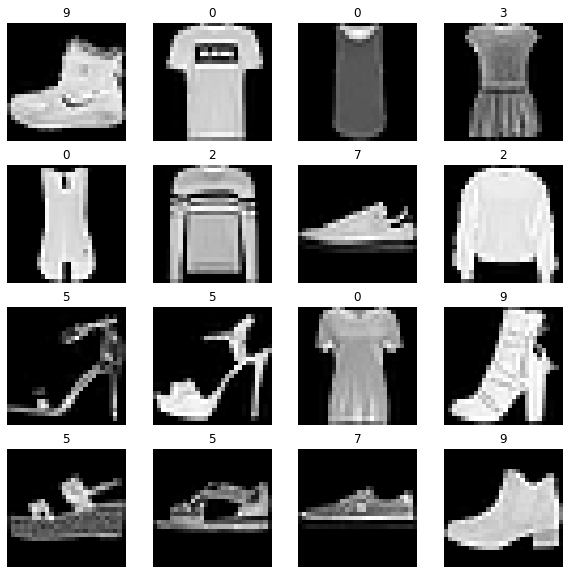

In [3]:
for images, classes in mnist_dataloader:
  columns = 4
  rows = 4
  fig = plt.figure(figsize=(10, 10))
  for i in range(0, columns*rows +1):
    img = images[i].squeeze()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,cmap="gray")
    plt.axis(False)
    plt.title(classes[i].item())
plt.show()
  

You have used a built-in dataset and configured dataloader associated with the dataset. Next, you are going to implement several Dataset objects dedicated to medical images. 

### Part II - MRI Dataloader (simple)

In the first part of the laboratory you loaded the built-in MNIST dataset.

However, in practice, you usually have your own dataset. Independent whether the dataset is public or private, it requires a dedicated Dataset object to load the assosciated images/volumes/annotations.

To implement your own Dataset object you need to:
<ul>
  <li> Create your own class with the **tc.utils.data.Dataset** as the parent class.
  <li> Overload the **__init__** function responsible for defining the parameters assosciated with the given Dataset and initializing the logic used during loading.
  <li> Overload the **__len__** function defining the size of the Dataset (number of cases).
  <li> Overload the **__getitem__** function responsible for loading a single case within the dataset (images + additional metadata like labels or annotations).
</ul>

In the first part you are going to use the dataset containing magnetic resonance images of brain dedicated to the tumor classification.

Please download the dataset from:

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri?resource=download

, and upload it to your Google Drive or directly to the Google Colaboratory **/content** folder.

If you plan to use the Google Drive (better option), you should:

On the left, under the **Files** bar, find a button called **Mount Drive** and choose your Google Drive.
It should appear in the **/content** folder as a **drive** or with different name if using non-default settings. Then you will need to unzip the dataset file to a selected path within your Google Drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
input_file = "/content/drive/MyDrive/DATASET_DATASET/archive.zip" # Path to the "Brain_MRI.zip"
output_folder = "/content/output" # Path to the folder where you would like to unzip the input ".zip" file

print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")

!unzip {input_file} -d {output_folder} # Do this only once, them comment out this command

Input file path: /content/drive/MyDrive/DATASET_DATASET/archive.zip
Output folder path: /content/output
Archive:  /content/drive/MyDrive/DATASET_DATASET/archive.zip
replace /content/output/Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Explore the unzipped data. You should see two folders inside the parent folder: **Training** and **Testing**. Inside these folders you will find four additional folders called: **pituitary_tumor**, **glioma**, **meningioma**, and **no_tumor**. All images inside these folder contain 2-D MRI slices presenting one of the classes.

Please note that the problem is simplfied - the cases are represented only by one 2-D slice from a 3-D MRI volume. In reality - the MRI imagaes are 3-D volumes containing hunderds of 2-D slices for each case.

The next task is to implement a dedicated Dataset object:

In [54]:
import imageio as iio
class BrainMRIDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path : str, mode : str="training"):
        self.dataset_path = dataset_path
        self.mode = mode # "training" or "testing"

        if self.mode == "training":
            self.data_path = os.path.join(self.dataset_path, "Training")
        elif self.mode == "testing":
            self.data_path = os.path.join(self.dataset_path, "Testing")
        else:
            raise ValueError("Unsupported mode.")

        self.classes = os.listdir(self.data_path) # Assumption that the classes are represented by the folder names
        print(f"Available classes: {self.classes}")
        self.classes_dict = {self.classes[i]: i for i in range(len(self.classes))}
        print(f"Classes dict: {self.classes_dict}") # Mapping from the classes to numbers

        # Creation of all training cases in the form of list containing tuples with: (path_to_file, class_number)
        self.cases = []
        for current_class in self.classes:
            print(current_class)

            for current_case in os.listdir(os.path.join(self.data_path, current_class)):
                self.cases.append((self.data_path,current_class))
    
    def __len__(self):
        # Overload the function responsible to determine the size of the dataset
        return len(self.classes)


    
    def __getitem__(self, idx):
        # Overload the function responsible to load a single image from the dataset
        transform_images_128 = tv.transforms.Compose([tv.transforms.Resize(size=(128,128)),tv.transforms.ToTensor()])
        reader = sitk.ImageFileReader()
        current_case = self.cases[idx]
        current_class = current_case[1]
        current_path = current_case[0]+"/"+current_class
        current_image = iio.imread(current_path)
        print(current_path +"\n" +current_class)
        current_image = transform_images_128(current_image)
        r, g, b = current_image[:,:,0], current_image[:,:,1], current_image[:,:,2]
        grayimg = 0.2989 * r + 0.5870 * g + 0.1140 * b

        # All images should have the same resolution
        # Resample the images to the same resolution (224x224), then convert the images to grayscale (if not already) and normalize to [0-1] values

        # TODO
    
        return current_path,current_class

Now create the DataLoader responsible for loading cases from the Dataset. Notice that you do not have to make any changes with respect to the DataLoader - the interface is the same as long as the Dataset is implemented correctly.

In [55]:
mri_dataset = BrainMRIDataset("/content/output") #TODO - create the dataset object
batch_size = 16
shuffle = True
mri_dataloader = tc.utils.data.DataLoader(dataset=mri_dataset, 
                              batch_size=batch_size)

Available classes: ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2, 'no_tumor': 3}
glioma_tumor
meningioma_tumor
pituitary_tumor
no_tumor


Finally, verify whether the images are loaded correctly:

In [56]:
images, classes = next(iter(mri_dataloader))
columns = 4
rows = 4
fig = plt.figure(figsize=(10, 10))
for i in range(0, columns*rows +1):
  img = images[i].squeeze()
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img,cmap="gray")
  plt.axis(False)
  plt.title(classes[i].item())
  plt.show()

ValueError: ignored

In this part you implemented a basic dataloader dedicated to MRI images. However, in practice, it is better to make the Dataset object a bit more complicated. This is the task for the next part.

### Part III - MRI Dataloader (extended)

In practice implementing the whole logic in the **__init__** function (as in the example above) is impractical. Better idea is to propose a unified representation and seperate the logic for pairing images with classes or other metadata outside the Dataset object.

The reason for this is connected with the fact that there may be more datasets than one that you would like to use at the same time and split or combine them whenever necessary. This is difficult if the datasets were acquired in different institutions without standarization.

Therefore, now slightly modify the Dataset from the previous Part by using **pandas** library to create and split the input dataset. The **csv** file should contain two columns: relative input path and the corresponding class. This way, you can firstly preprocess different datasets to the same representation and then combine them or split using just the **csv** file.

Note: In practice, for larger dataset, instead of using **csv** files you use tools dedicated to databases.

First, parse the dataset into a csv representation:

In [58]:
import pandas as pd

dataset_path = output_folder
training_csv_path = os.path.join(dataset_path, "training.csv")
testing_csv_path = os.path.join(dataset_path, "testing.csv")

# Repeat the process from the __init__ function to create pandas dataframe
# containing three components: (image_path, image_class_number, image_class_name)

test = os.listdir("/content/output/Testing")
print(test)







classes = None# TODO list all the available classes
print(f"Available classes: {classes}")
classes_dict = {classes[i]: i for i in range(len(classes))}
print(f"Classes dict: {classes_dict}")

training_cases = []
testing_cases = []
for current_class in classes:
    pass
    # TODO - populate both the training and testing cases with the tuples

# TODO - create the dataframes and save them to .csv

['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
Available classes: None


TypeError: ignored

Now modify the Dataset class to use **csv** files instead of implementing the logic inside the **init** function.

In [ ]:
class BrainDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataset_path = dataset_path
        self.dataframe = None # TODO - read the previously created csv

    def __len__(self):
        pass # TODO

    def __getitem__(self, idx):
        # TODO - repeat the steps from the previous dataloader
        current_image = None
        current_class = None
        return current_image, current_class

And now again verify whether everything works correctly by creating the DataLoader and showing an exemplary batch from the training dataset:

In [ ]:
batch_size = 16
shuffle = True
training_dataset = BrainDataset(os.path.join(dataset_path, "Training"), training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

for images, classes in training_dataloader:
    # TODO - perform the same visualization as before but this time using the new version of the dataset
    break

You should be now familiar with implementing your own Datasets. The next part is for you to train - you are going to implement another one from scratch, without any additional guides.

### Part IV - Endoscopy Dataloader

In this part you are going to implement dataset dedicated to image segmentation (to be then used during Laboratory 6). 

The dataset is dedicated to the segmentation of surgical instruments from endoscopy images and comes from:

https://www.kaggle.com/datasets/debeshjha1/kvasirinstrument

We will use the dataset during Laboratory 6 because endoscopy images are relatively low resolution 2-D images than can be easily processed using Google Colaboratory. In reality they are video sequences, however, you are going to process just single frames.

Download the dataset and repeat the steps from the previous parts of the laboratory. Start with creating the dataset:

In [34]:
input_file = "/content/drive/MyDrive/kvasirdataset/archive.zip"
output_folder = "/content/custom_output" 

print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")

!unzip {input_file} -d {output_folder}

Input file path: /content/drive/MyDrive/kvasirdataset/archive.zip
Output folder path: /content/custom_output
Archive:  /content/drive/MyDrive/kvasirdataset/archive.zip
  inflating: /content/custom_output/kvasir-instrument/bboxes.json  
  inflating: /content/custom_output/kvasir-instrument/images/images/ckcu8ty6z00003b5yzfaezbs5.jpg  
  inflating: /content/custom_output/kvasir-instrument/images/images/ckcu8v7pr00013b5ymfi2z7uf.jpg  
  inflating: /content/custom_output/kvasir-instrument/images/images/ckcu8w7vy00023b5y3vt2wczx.jpg  
  inflating: /content/custom_output/kvasir-instrument/images/images/ckcu8xad600033b5yc78xfyjx.jpg  
  inflating: /content/custom_output/kvasir-instrument/images/images/ckcu99qx200043b5yd2c5g84t.jpg  
  inflating: /content/custom_output/kvasir-instrument/images/images/ckcu9ejjf00053b5y4mf7bilw.jpg  
  inflating: /content/custom_output/kvasir-instrument/images/images/ckcu9ij2e00063b5yrrbb3f2o.jpg  
  inflating: /content/custom_output/kvasir-instrument/images/ima

Then create the dataloader:

In [39]:
from torchvision import transforms,datasets
from pathlib import Path
dir =Path("/content/custom_output/kvasir-instrument/images/images")
dataset = datasets.ImageFolder(root=dir)

TypeError: ignored

And finally visualize the images with the corresponding segmentation masks:

In [ ]:
# TODO

### Conclusion

Congratulations, you have implemented several datasets dedicated to load medical images. You should be now able to implement you own dataset whenever necessary.

After the laboratory you should:
<ul>
  <li> Understand the difference between Dataset and Dataloader objects.
  <li> Implement your own Dataset object for a given medical dataset.
  <li> Use the Dataloader object with any Dataset to load the data using the desired hyperparameters.
  <li> Verify whether the Dataloader works and loads the data appropriately.
</ul>

During the next laboratory you are going to combine the knowledge from Laboratory 2 and Laboratory 3 to implement and train a simple convolutional neural network for medical image classification.